<a href="https://colab.research.google.com/github/rll/deepul/blob/master/demos/lecture3_latent_variable_models_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started
Go to **Runtime -> Change runtime type** and make sure **Hardward accelerator** is set to **GPU**

In [0]:
!if [ -d cs294-158-lvm-master ]; then rm -Rf cs294-158-lvm-master; fi
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1qp9N1EJFAllLcGh2l83zqPHsqdDoq14Q' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1qp9N1EJFAllLcGh2l83zqPHsqdDoq14Q" -O cs294-158-lvm-master.zip && rm -rf /tmp/cookies.txt
!unzip -qq cs294-158-lvm-master.zip
!rm cs294-158-lvm-master.zip
!pip install cs294-158-lvm-master/

In [0]:
%matplotlib inline

# Demo 1: A Simple Latent Variable Model (LVM)
In this demo, we train a simple LVM modeled as $z \sim \text{Multinomial}(4), x \sim N(\mu_\theta(z), 1)$, where $\mu_\theta(z)$ is a small neural network outputting the mean of a guassian. We fit this LVM using maximum likelhood by marginalizing out $z$.

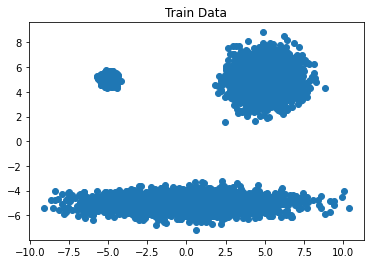

In [0]:
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from deepul_helper.data import sample_three_blobs
from deepul_helper.visualize import plot_scatter_2d
from deepul_helper.models import MLP
from deepul_helper.trainer import train_epochs

train_data = sample_three_blobs(10000)
test_data = sample_three_blobs(2500)
plot_scatter_2d(train_data, title='Train Data')


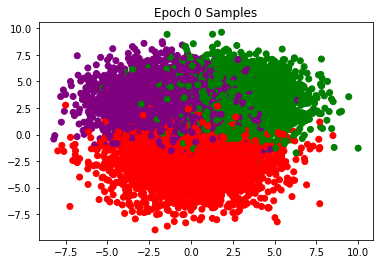

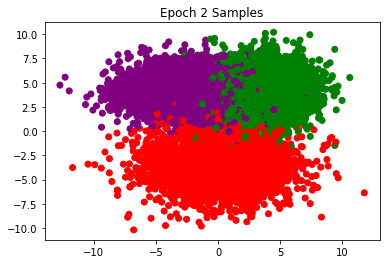

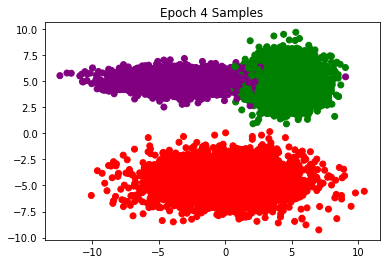

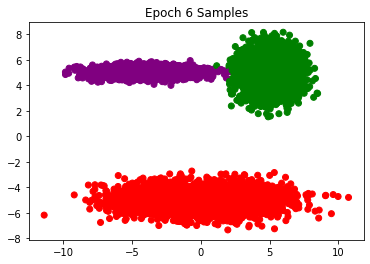

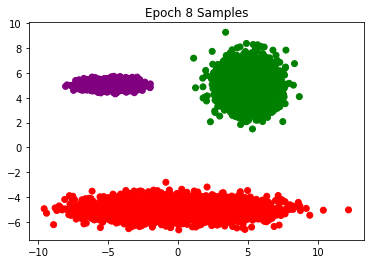

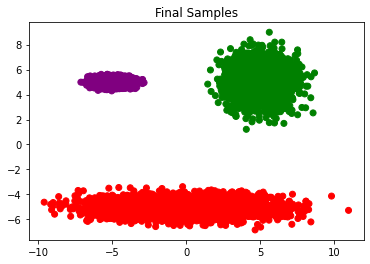

In [0]:
class SimpleLVM(nn.Module):
    def __init__(self, n_mix):
        super().__init__()

        self.n_mix = n_mix
        self.pi_logits = nn.Parameter(torch.zeros(n_mix, dtype=torch.float32), requires_grad=True)
        self.mus = nn.Parameter(torch.randn(n_mix, 2, dtype=torch.float32), requires_grad=True)
        self.log_stds = nn.Parameter(-torch.ones(n_mix, 2, dtype=torch.float32), requires_grad=True)

    def loss(self, x):
        log_probs = []
        for i in range(self.n_mix):
            mu_i, log_std_i = self.mus[i].unsqueeze(0), self.log_stds[i].unsqueeze(0)
            log_prob = -0.5 * (x - mu_i) ** 2 * torch.exp(-2 * log_std_i)
            log_prob = log_prob - 0.5 * np.log(2 * np.pi) - log_std_i
            log_probs.append(log_prob.sum(1))
        log_probs = torch.stack(log_probs, dim=1)

        log_pi = F.log_softmax(self.pi_logits, dim=0)
        log_probs = log_probs + log_pi.unsqueeze(0)
        loss = -torch.logsumexp(log_probs, dim=1).mean()
        return OrderedDict(loss=loss)

    def sample(self, n):
        with torch.no_grad():
            probs = F.softmax(self.pi_logits, dim=0)
            labels = torch.multinomial(probs, n, replacement=True)
            mus, log_stds = self.mus[labels], self.log_stds[labels]
            x = torch.randn(n, 2) * log_stds.exp() + mus
        return x.numpy(), labels.numpy()

train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=128)
device = torch.device('cpu')

n_mix = 3
model = SimpleLVM(n_mix)

def fn(epoch):
    x, labels = model.sample(10000)
    plot_scatter_2d(x, title=f'Epoch {epoch} Samples', labels=labels)

train_epochs(model, train_loader, test_loader, device, dict(epochs=10, lr=7e-2),
             fn=fn, fn_every=2, quiet=True)

x, labels = model.sample(10000)
plot_scatter_2d(x, title='Final Samples', labels=labels)

# Demo 2: Score Function Estimator vs Pathwise Derivative
In this demo, we compare optimizing a simple objective using the score function estimator verses the pathwise derivative. The goal is to learn the mean of a Gaussian distribution to reach the location (5, 5).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

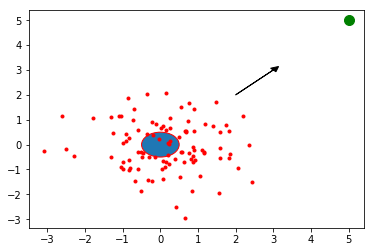

In [0]:
mean_npy = np.zeros(2)
target_mean = np.array([5, 5])

mu_init = np.zeros(2)
popsize=100
xsamp = np.random.randn(popsize, 2) + mu_init[None]
target_point = np.array([5., 5.])
plt.clf()
plt.plot(xsamp[:, 0], xsamp[:, 1], 'r.', label='samp')
plt.plot(target_point[0], target_point[1], 'g.', ms=20, label='target_samp')
el = Ellipse(xy=mu_init, width=2*0.5, height=2*0.5, angle=0)
el.set_edgecolor('red')
plt.arrow(2, 2, 1, 1, head_width=.2, head_length=.2, fc='k', ec='k')
plt.gca().add_artist(el)
plt.show()

In [0]:
##### PD (Pathwise Derivative) Update #####

def pd_update(*, mu, target_mu, step_size=0.1, n_samples=1):
  """
    sample drawn as mu + eps * sigma
    reward =  -(sample - target_mu)**2
  """
  samples = np.random.randn(n_samples, 2) + mu[None]
  grad_estim = -np.mean(samples - target_mu[None], axis=0)
  mu = mu + step_size * grad_estim
  return mu

#### SF (Score Function) Update ####

def sf_update(*, mu, target_mu, step_size=0.1, n_samples=1):
  """
    reward = -(mu - target_mu)**2
    grad_log_mu = (sample - mu) for gaussian with std=1 (check yourself)
  """
  samples = np.random.randn(n_samples, 2) + mu[None]
  rewards = -np.sum((samples- target_mu[None])**2, axis=1)
  grad_log_mu = (samples - mu[None])
  grad_estim = np.mean(rewards[:, None] * grad_log_mu, axis=0)
  mu = mu + step_size * grad_estim
  return mu

In [0]:
def plot_training(update_method):
  # Visualize SF
  step_size = 0.05
  mu = np.zeros(2)
  n_samples=1

  for _ in range(20):
    plt.clf()
    plt.plot(target_point[0], target_point[1], 'g.', ms=20, label='target_samp')
    el = Ellipse(xy=mu, width=2*0.5, height=2*0.5, angle=0)
    el.set_edgecolor('red')
    plt.gca().add_artist(el)
    plt.axis([-10, 10, -10, 10])

    # plt.show()
    plt.pause(1)
    mu = update_method(mu=mu, target_mu=target_mean, n_samples=n_samples, step_size=step_size)

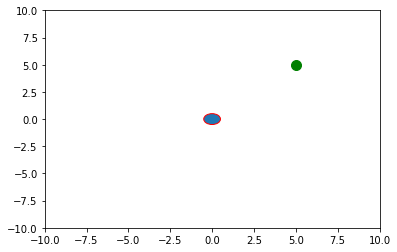

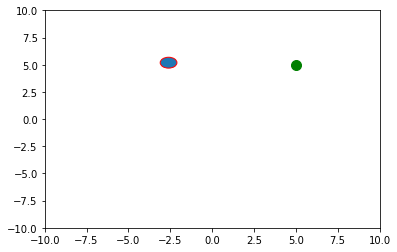

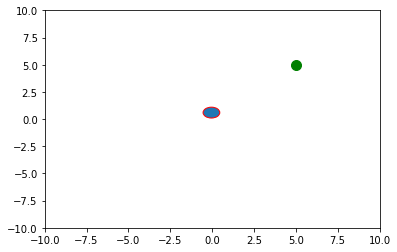

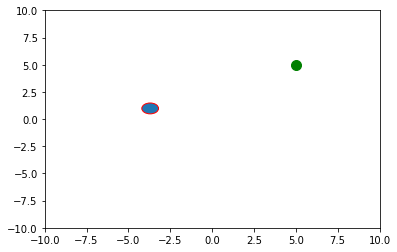

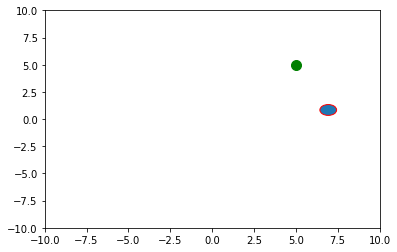

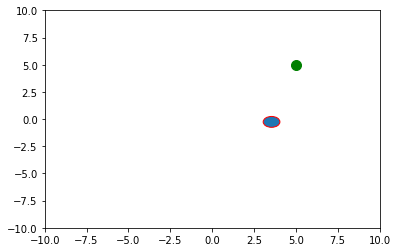

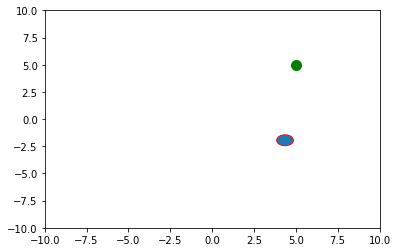

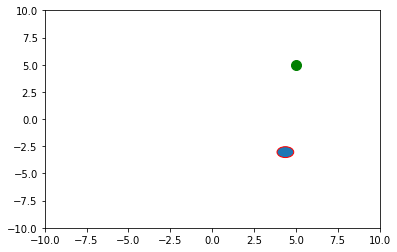

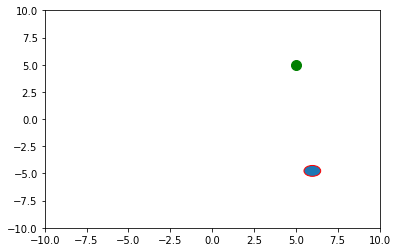

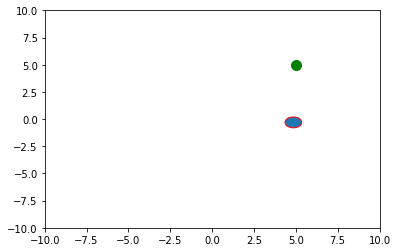

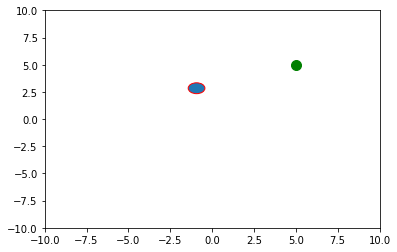

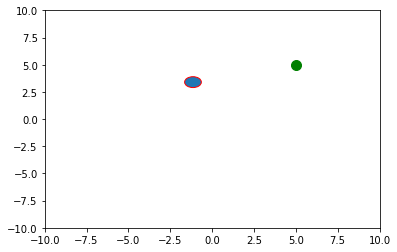

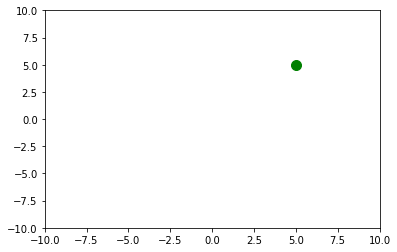

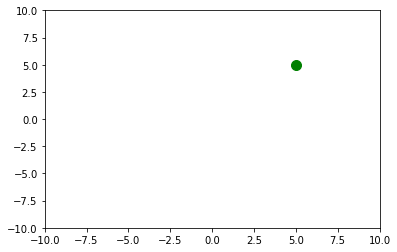

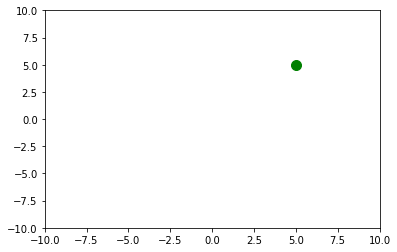

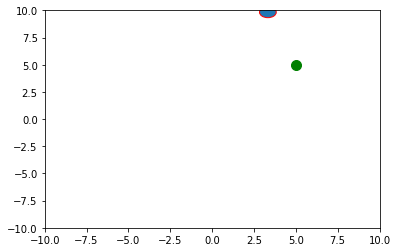

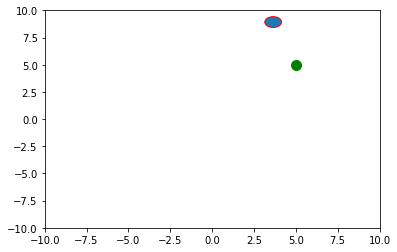

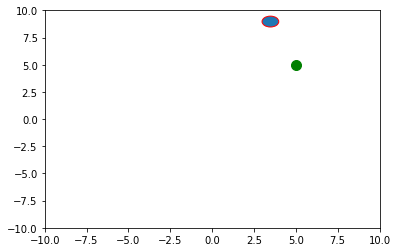

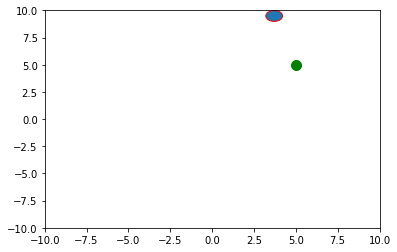

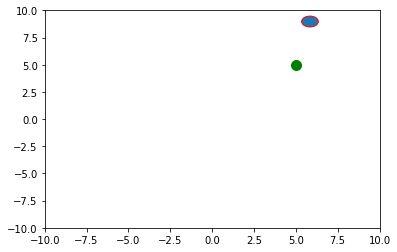

In [0]:
plot_training(sf_update)

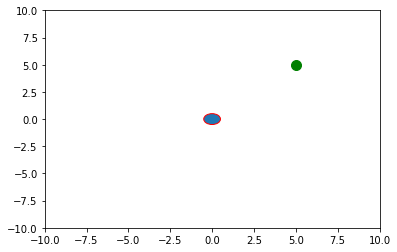

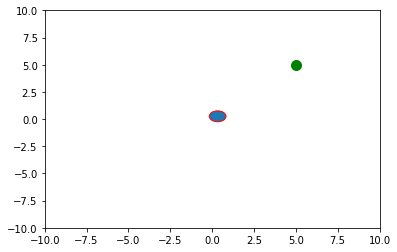

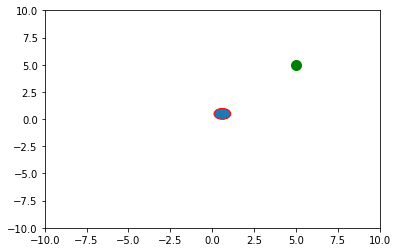

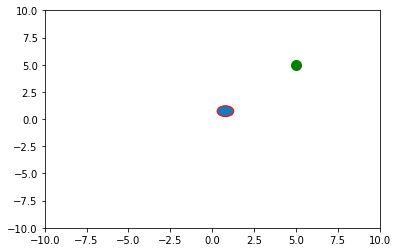

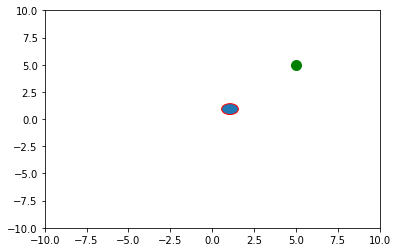

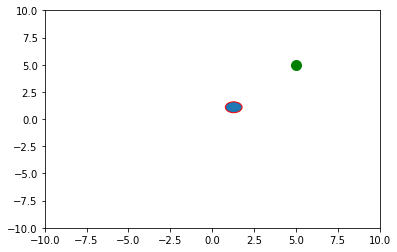

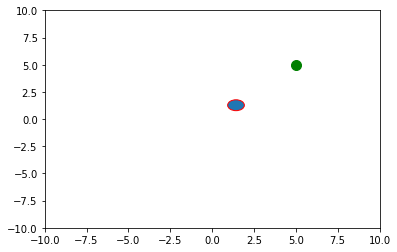

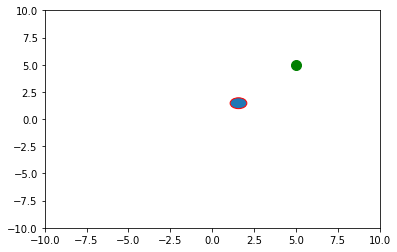

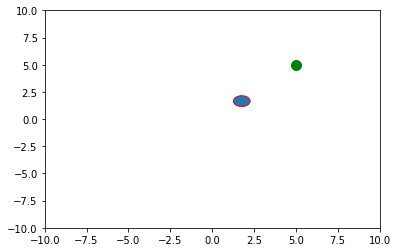

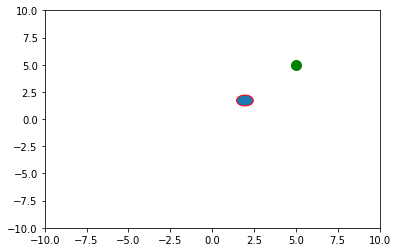

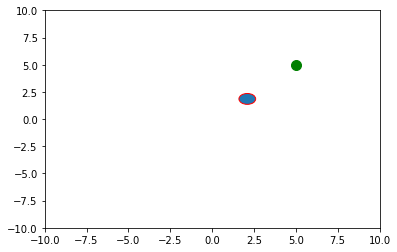

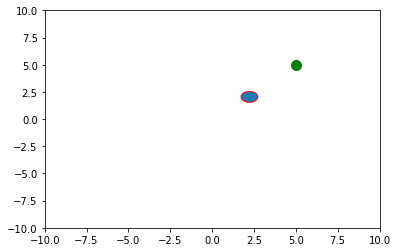

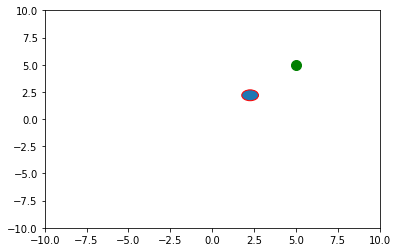

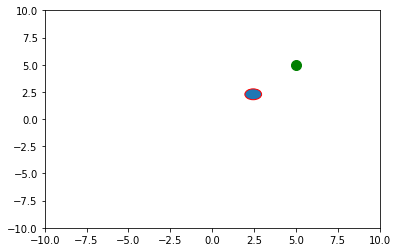

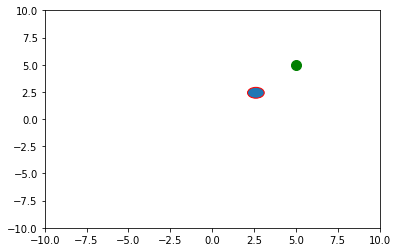

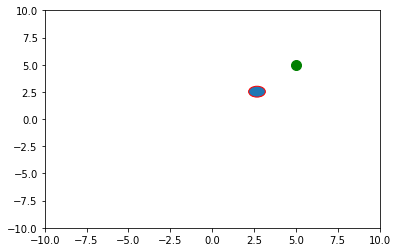

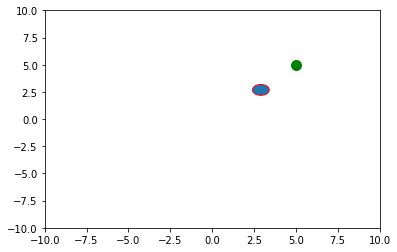

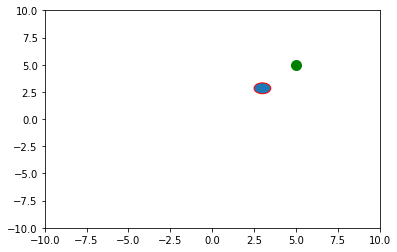

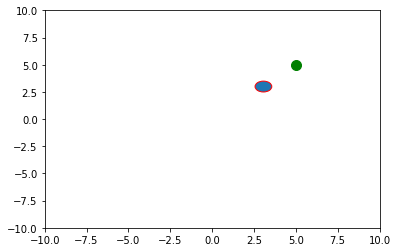

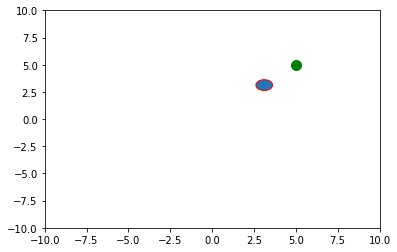

In [0]:
plot_training(pd_update)

 # Demo 3: VAEs on 2D Data
 In this demo, we show how the latent space is structured when learning a simple 2D distribution with three general clusters of points. We train a VAE with a 2D isotropic Gaussian for the latents.

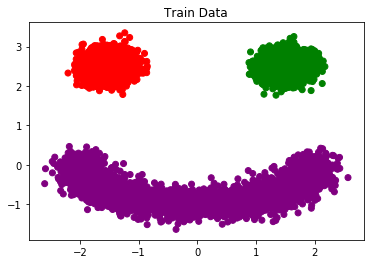

In [0]:
import torch
import torch.utils.data as data

from deepul_helper.data import sample_smiley_data
from deepul_helper.visualize import plot_scatter_2d
from deepul_helper.models import FullyConnectedVAE
from deepul_helper.trainer import train_epochs
from deepul_helper.distributions import Normal

train_data, train_labels = sample_smiley_data(100000)
test_data, test_labels = sample_smiley_data(25000)
plot_scatter_2d(train_data[:10000], title='Train Data', labels=train_labels[:10000])

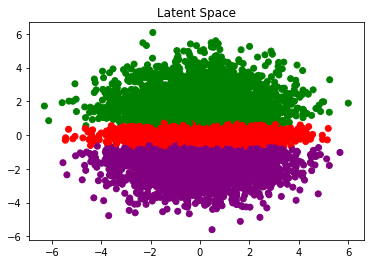

In [0]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda')

enc_dist, dec_dist = Normal(), Normal()
prior = Normal(torch.cat((torch.zeros(1, 2), torch.ones(1, 2)), dim=1).to(device))
vae = FullyConnectedVAE(2, 2, enc_dist, dec_dist, prior,
                        enc_hidden_sizes=[128, 128], dec_hidden_sizes=[128, 128],
                        beta=1).to(device)


train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=128, shuffle=False)

train_epochs(vae, train_loader, test_loader, device, dict(epochs=10, lr=1e-3), quiet=True)

x = torch.FloatTensor(train_data[:10000]).to(device)
with torch.no_grad():
    z = vae.encode(x)
    x_recon = vae.decode(z, sample=False)
z, x_recon = z.cpu().numpy(), x_recon.cpu().numpy()
plot_scatter_2d(z, title='Latent Space', labels=train_labels[:10000])

# Demo 4: Posterior Collapse on Toy Datasets
In this demo, we investigate posterior collapse on small toy datasets. Posterior collapse occurs when $q(z|x) = p(z)$. It is important to remember that even though a VAE is called a Variation **Autoencoder**, it is not an autoencoder in the truest since, as training a VAE is trying to maximize the likelihood $p(x)$. If your decoder $p(x|z)$ is powerful enough, it can model $p(x|z) = p(x)$ and ignore any generated latents, resulting in posterior collapse. We look at two toy datasets to demonstrate this fact.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import torch
import torch.utils.data as data

from deepul_helper.models import FullyConnectedVAE
from deepul_helper.trainer import train_epochs
from deepul_helper.distributions import Normal, Bernoulli
from deepul_helper.visualize import plot_scatter_2d
from deepul_helper.data import sample_diag_guass_data, sample_cov_gauss_data

## Autoencoding a Single Bit
Check [this blog post](http://ruishu.io/2017/01/14/one-bit/) for a more in-depth analysis

First, we look at a dataset with two points, and try to autoencode a single bit of information. Note that no matter how you train it, the loss will converge to $\log{2} = 0.693$ with a KL of about zero since the decoder is powerful enough to model $p(x)$ on its own.

In [0]:
def train_bern_vae(train_data):
    device = torch.device('cpu')
    enc_dist, dec_dist = Normal(), Bernoulli()
    prior = Normal(torch.FloatTensor([[0, 1]]))
    vae = FullyConnectedVAE(train_data.shape[1], 1, enc_dist, dec_dist, prior,
                            enc_hidden_sizes=[32], dec_hidden_sizes=[32],
                            beta=1)
    data_loader = data.DataLoader(train_data, batch_size=1, shuffle=True)
    losses = train_epochs(vae, data_loader, None, device, dict(epochs=1000, lr=2e-4))
    for k, v in losses.items():
        losses[k] = gaussian_filter1d(np.array(v, dtype='float32'), 5)

    plt.figure()
    plt.title('Train Losses')
    plt.xlabel('Iteration')
    plt.plot(losses['loss'], label='-ELBO')
    plt.plot(losses['recon_loss'], label='Recon Loss')
    plt.plot(losses['kl_loss'], label='KL Loss')
    plt.legend()
    plt.show()

Test loss 0.3278, recon_loss 0.3276, kl_loss 0.0002


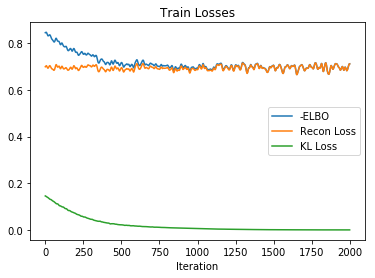

In [0]:
train_bern_vae(np.array([[0.], [1.]], dtype='float32'))

We can force the latents to be used by adding extra dimensionality. There is still 2 bits of information, but the decoder is not powerful enough to model the $p(x)$ on its own. Note the non-zero KL loss

Test loss 1.7823, recon_loss 1.4657, kl_loss 0.3165


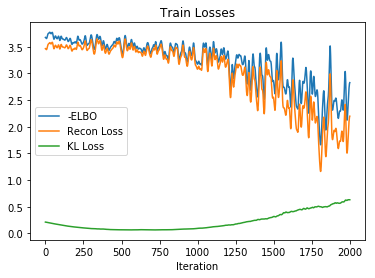

In [0]:
train_bern_vae(np.array([[0., 0., 0., 0., 0.], [1., 1., 1., 1., 1.]], dtype='float32'))


## 2D Gaussian Data
Now, we look at posterior collapse in 2D data. 

In [0]:
def train_gauss_vae(data_fn):
    train_data = data_fn(10000)
    test_data = data_fn(2500)
    device = torch.device('cuda')

    enc_dist, dec_dist = Normal(), Normal()
    prior = Normal(torch.cat((torch.zeros(1, 2), torch.ones(1, 2)), dim=1).to(device))
    vae = FullyConnectedVAE(2, 2, enc_dist, dec_dist, prior,
                            enc_hidden_sizes=[128, 128], dec_hidden_sizes=[128, 128],
                            beta=1).to(device)

    plot_scatter_2d(train_data[:10000], title='Train Data')

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128, shuffle=False)

    losses = train_epochs(vae, train_loader, test_loader, device, dict(epochs=20, lr=1e-3))

    for k, v in losses.items():
        losses[k] = gaussian_filter1d(np.array(v, dtype='float32'), 5)

    plt.figure()
    plt.title('Train Losses')
    plt.xlabel('Iteration')
    plt.plot(losses['loss'], label='-ELBO')
    plt.plot(losses['recon_loss'], label='Recon Loss')
    plt.plot(losses['kl_loss'], label='KL Loss')
    plt.legend()
    plt.show()

    samples = vae.sample(1000, decoder_noise=True).numpy()
    plot_scatter_2d(samples, title='Samples (with decoder noise)')
    samples = vae.sample(1000, decoder_noise=False).numpy()
    plot_scatter_2d(samples, title='Samples (without decoder noise)')

First, our dataset is sampled from a multivariate gaussian with diagonal covariance. Note that our decoder is also a learned multivariate guassian with diagonal covariance, so theoretically, we should see posterior collapse as $p(x|z)$ can model $p(x)$.

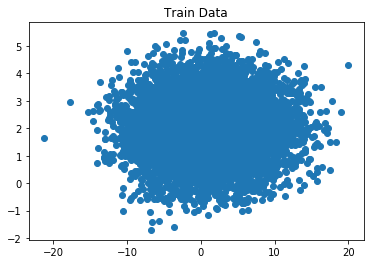

Test loss 0.0018, recon_loss 0.0018, kl_loss 0.0000


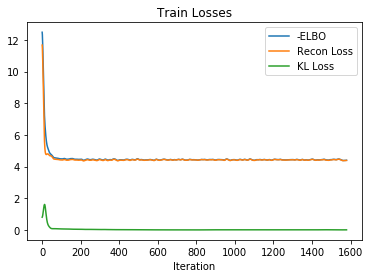

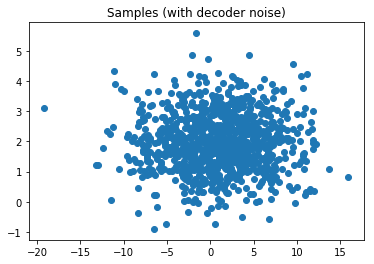

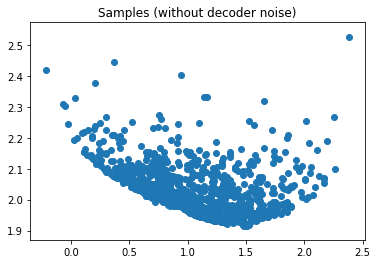

In [0]:
train_gauss_vae(sample_diag_guass_data)


Now, we consider a dataset generated by a multivariate gaussian with a full covariance matrix (non-diagonal). In this case, the decoder is not powerful enough to cause posterior collapse, and the latents should be used.

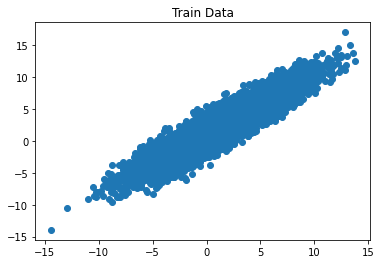

Test loss 0.0018, recon_loss 0.0011, kl_loss 0.0006


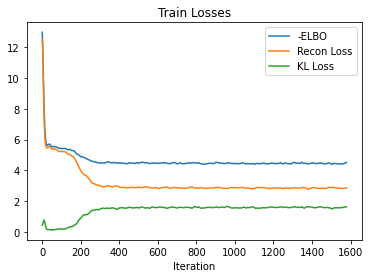

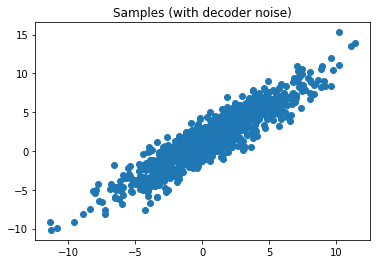

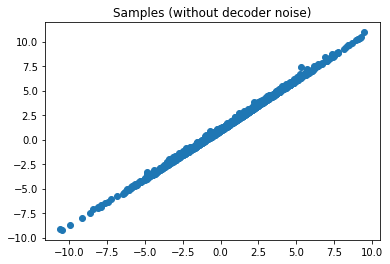

In [0]:
train_gauss_vae(sample_cov_gauss_data)


# Demo 6: VAEs on MNIST
In this demo, we show an example of training a standard VAE on MNIST digits

In [0]:
import numpy as np
import torch
import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms

from deepul_helper.models import ConvVAE, FullyConnectedVAE
from deepul_helper.trainer import train_epochs
from deepul_helper.distributions import Normal, Bernoulli
from deepul_helper.visualize import visualize_batch

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dset = datasets.MNIST('data', transform=transform, train=True, download=True)
test_dset = datasets.MNIST('data', transform=transform, train=False, download=True)

train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True, pin_memory=True,
                               num_workers=2)
test_loader = data.DataLoader(test_dset, batch_size=128, pin_memory=True, num_workers=2)

device = torch.device('cuda')
latent_size = 8
enc_dist, dec_dist = Normal(), Normal(use_mean=True)
prior = Normal(torch.cat((torch.zeros(1, latent_size), torch.ones(1, latent_size)), dim=1).to(device))
mnist_vae = FullyConnectedVAE((1, 28, 28), 8, enc_dist, dec_dist, prior,
                              enc_hidden_sizes=[512, 512], dec_hidden_sizes=[512, 512],
                              output_activation=torch.tanh).to(device)
train_epochs(mnist_vae, train_loader, test_loader, device, dict(epochs=10, lr=1e-3), quiet=True)

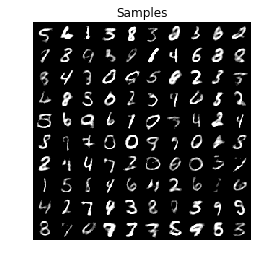

In [0]:
samples = mnist_vae.sample(100, decoder_noise=False)
visualize_batch(samples * 0.5 + 0.5, nrow=10, title='Samples')

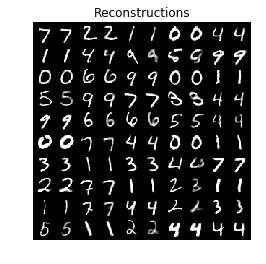

In [0]:
with torch.no_grad():
    x = next(iter(test_loader))[0][:50].to(device)
    z = mnist_vae.encode(x)
    x_recon = mnist_vae.decode(z, sample=False)
    images = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28).cpu()
visualize_batch(images * 0.5 + 0.5, nrow=10, title='Reconstructions')

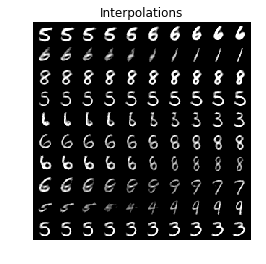

In [0]:
with torch.no_grad():
    x = next(iter(train_loader))[0][:20].to(device)
    z1, z2 = mnist_vae.encode(x).chunk(2, dim=0)
    zs = [z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, 10)]
    zs = torch.stack(zs, dim=1).view(-1, latent_size)
    xs = mnist_vae.decode(zs, sample=False).cpu()
visualize_batch(xs * 0.5 + 0.5, nrow=10, title='Interpolations')

# Demo 7: Posterior Collapse on Higher Dimensional Data
In this demo, we investigate posterior collapse on higher dimensional (image) data. This is most commonly seen when a powerful decoder, such as a PixelCNN autoregressive model, is used as a decoder.

In [0]:
import torch
import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms

from deepul_helper.models import PixelVAE, AFPixelVAE, IAFPixelVAE
from deepul_helper.trainer import train_epochs
from deepul_helper.visualize import visualize_batch
from deepul_helper.distributions import Normal

def run_demo7(pixel_vae):
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    transform = transforms.Compose([
        transforms.ToTensor(),
        lambda x: (x > 0.5).float()
    ])
    train_dset = datasets.MNIST('data', transform=transform, train=True, download=True)
    test_dset = datasets.MNIST('data', transform=transform, train=False, download=True)

    train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True, pin_memory=True,
                                   num_workers=2)
    test_loader = data.DataLoader(test_dset, batch_size=128, pin_memory=True, num_workers=2)

    train_epochs(pixel_vae, train_loader, test_loader, device, dict(epochs=10, lr=1e-3), quiet=True)

    # Reconstructions
    with torch.no_grad():
        x = next(iter(test_loader))[0][:50].to(device)
        z = pixel_vae.encode(x)
        x_recon = pixel_vae.decode(z)
        images = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28).cpu()
    visualize_batch(images, nrow=10, title='Reconstructions')

    # Samples
    samples = pixel_vae.sample(100).cpu()
    visualize_batch(samples, nrow=10, title='Samples')

device = torch.device('cuda')
latent_size = 8
enc_dist = Normal()
prior = Normal(torch.cat((torch.zeros(1, latent_size), torch.ones(1, latent_size)), dim=1).to(device))


## Standard PixelVAE
Using a standard VAE with a PixelCNN decoder, we will see that reconstructions are not very accurate (but still within distribution), indicated that latents are being ignored

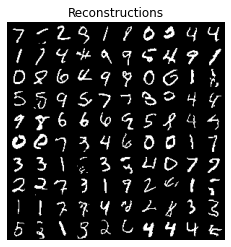

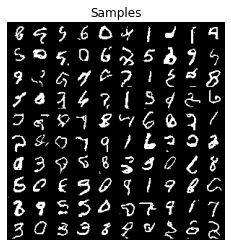

In [0]:
pixel_vae = PixelVAE(device, (1, 28, 28), latent_size, enc_dist, prior,
                     enc_conv_sizes=((3, 64, 2), (3, 64, 2))).to(device)
run_demo7(pixel_vae)

## PixelVAE with Free Bits
You can allocate a certain number of "free bits" that the model may use without penalty to prevent posterior collapse. Using $k$ free bits, the regularization loss for a VAE is now $\min(k, KL(p(z) || q(z|x)))$

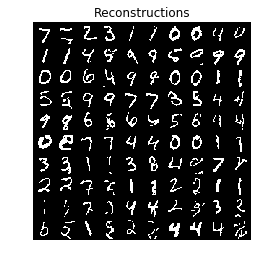

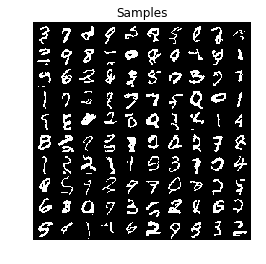

In [0]:
pixel_vae_free_bits = PixelVAE(device, (1, 28, 28), latent_size, enc_dist, prior,
                               enc_conv_sizes=((3, 64, 2), (3, 64, 2)), free_bits=10).to(device)
run_demo7(pixel_vae_free_bits)

## PixelVAE with an AF Prior
A possible solution is to increase the expressivity of the prior using an autoregressive flow. We can see the reconstructions are more accurate.

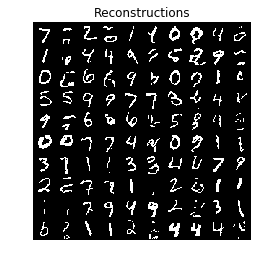

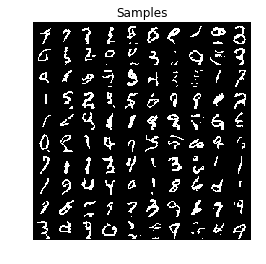

In [0]:
af_vae = AFPixelVAE(device, (1, 28, 28), latent_size, enc_dist,
                    enc_conv_sizes=((3, 64, 2), (3, 64, 2)), made_hidden_sizes=[512, 512], n_mades=2).to(device)
run_demo7(af_vae)

## PixelVAE with an IAF Posterior
Another possible solution is to increase the expressivity of the posterior with an inverse autoregressive flow. We can see the reconstructions are more accurate

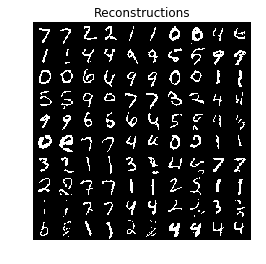

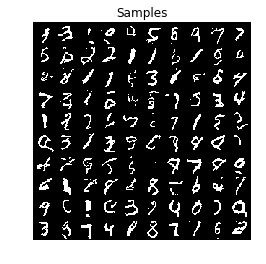

In [0]:
iaf_vae = IAFPixelVAE(device, (1, 28, 28), latent_size, prior,
                      enc_conv_sizes=((3, 64, 2), (3, 64, 2)), made_hidden_sizes=[512, 512],
                      embedding_size=128).to(device)
run_demo7(iaf_vae)

# Demo 8: Discrete VAEs (VQ-VAE and Gumbel-Softmax VAE)
So far we've only looked at VAEs with continuous priors and posteriors, primarily because they are easier to optimize through the reparameterization trick. However, a few methods exist to train discrete VAEs.

In [0]:
import torch
import torch.utils.data as data
from torchvision import datasets
from torchvision import transforms

from deepul_helper.models import VectorQuantizedVAE, PixelCNN, GumbelVAE
from deepul_helper.trainer import train_epochs
from deepul_helper.visualize import visualize_batch

seed = 2
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])
train_dset = datasets.MNIST('data', transform=transform, train=True, download=True)
test_dset = datasets.MNIST('data', transform=transform, train=False, download=True)

train_loader = data.DataLoader(train_dset, batch_size=128, shuffle=True, pin_memory=True,
                               num_workers=2)
test_loader = data.DataLoader(test_dset, batch_size=128, pin_memory=True, num_workers=2)
device = torch.device('cuda')

## VQ-VAE
First, we look at the VQ-VAE, which learned discrete latents using dictionary embeddings.

Training VQVAE


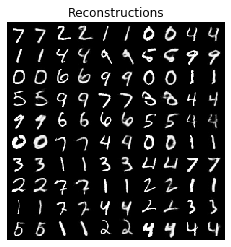

Trainign PixelCNN Prior


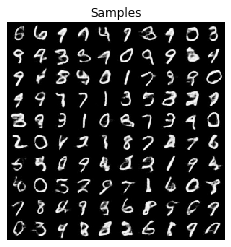

In [0]:
# VQ-VAE
print('Training VQVAE')
vqvae = VectorQuantizedVAE(64, 4, 1).to(device)
train_epochs(vqvae, train_loader, test_loader, device, dict(epochs=10, lr=1e-3), quiet=True)

with torch.no_grad():
    x = next(iter(test_loader))[0][:50].to(device)
    z = vqvae.encode_code(x)
    x_recon = vqvae.decode_code(z)
    images = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28).cpu()
visualize_batch(images, nrow=10, title='Reconstructions')

def construct_z_dset(vqvae, data_loader):
    zs = []
    for x, _ in data_loader:
        with torch.no_grad():
            x = x.to(device)
            zs.append(vqvae.encode_code(x).unsqueeze(1).cpu())
    zs = torch.cat(zs, dim=0)
    return zs

train_z_dset = construct_z_dset(vqvae, train_loader)
test_z_dset = construct_z_dset(vqvae, test_loader)
train_z_loader = data.DataLoader(train_z_dset, batch_size=128, shuffle=True, pin_memory=True,
                                 num_workers=2)
test_z_loader = data.DataLoader(test_z_dset, batch_size=128, pin_memory=True, num_workers=2)

print('Training PixelCNN Prior')
pixelcnn_prior = PixelCNN(device, 4, n_layers=10).to(device)
train_epochs(pixelcnn_prior, train_z_loader, test_z_loader, device, 
             dict(epochs=20, lr=1e-3), quiet=True)

with torch.no_grad():
    samples = pixelcnn_prior.sample(100).squeeze(1).long().to(device)
    samples = vqvae.decode_code(samples).cpu()
visualize_batch(samples, nrow=10, title='Samples')

## Gumbel-Softmax VAE
Next, we look at the [Gumbel-Softmax VAE](https://arxiv.org/pdf/1611.01144.pdf), which optimizes a categorical latent code using the Gumbel-Softmax reparameterization trick.

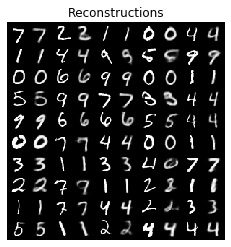

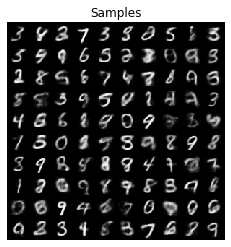

In [0]:
# Gumbel Softmax VAE
gumbel_vae = GumbelVAE(30, 10).to(device)
train_epochs(gumbel_vae, train_loader, test_loader, device, dict(epochs=20, lr=1e-3), quiet=True)

gumbel_vae.temp = 0.1
gumbel_vae.hard = True
with torch.no_grad():
    x = next(iter(test_loader))[0][:50].to(device)
    x_recon, _ = gumbel_vae(x)
    x_recon = x_recon.view(-1, 1, 28, 28)
    xs = torch.stack((x, x_recon), dim=1).view(-1, 1, 28, 28).cpu()
visualize_batch(xs, nrow=10, title='Reconstructions')

samples = gumbel_vae.sample(100)
visualize_batch(samples, nrow=10, title='Samples')
